In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
class ISICDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)

        # Modify the mask name to match the image name
        mask_name = img_name.replace(".jpg", "_Segmentation.png")
        mask_path = os.path.join(self.masks_dir, mask_name)

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        raw_image = image

        # Apply transforms
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            raw_image = self.mask_transform(raw_image)

        # Convert mask to binary (0 and 1) if needed
        mask = (np.asarray(mask, dtype=np.float32) > 0).astype(np.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask, raw_image

In [3]:
data_dir = "../data"

images_dir = f"{data_dir}/training_images"
masks_dir = f"{data_dir}/training_masks"

normalize_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Initialize dataset
dataset = ISICDataset(images_dir=images_dir, masks_dir=masks_dir, image_transform=normalize_transform, mask_transform=normalize_transform)

# Initialize dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# Calculate mean and std
mean = 0.0
std = 0.0
nb_samples = 0.0

for data, _, _ in dataloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print("Mean:", mean.numpy())
print("Std:", std.numpy())

Mean: [0.7238532  0.61864924 0.5672044 ]
Std: [0.10314404 0.12677965 0.1492761 ]


In [4]:
# Transform for images
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Transform for masks
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [5]:
# Initialize dataset
dataset = ISICDataset(images_dir=images_dir, masks_dir=masks_dir, image_transform=image_transform, mask_transform=mask_transform)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Get images and masks batch shapes
images, masks, raw = next(iter(dataloader))
print(f"Image batch shape: {images.shape}")
print(f"Mask batch shape: {masks.shape}")
print(f"Raw batch shape: {raw.shape}")

Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 1, 256, 256])
Raw batch shape: torch.Size([8, 3, 256, 256])


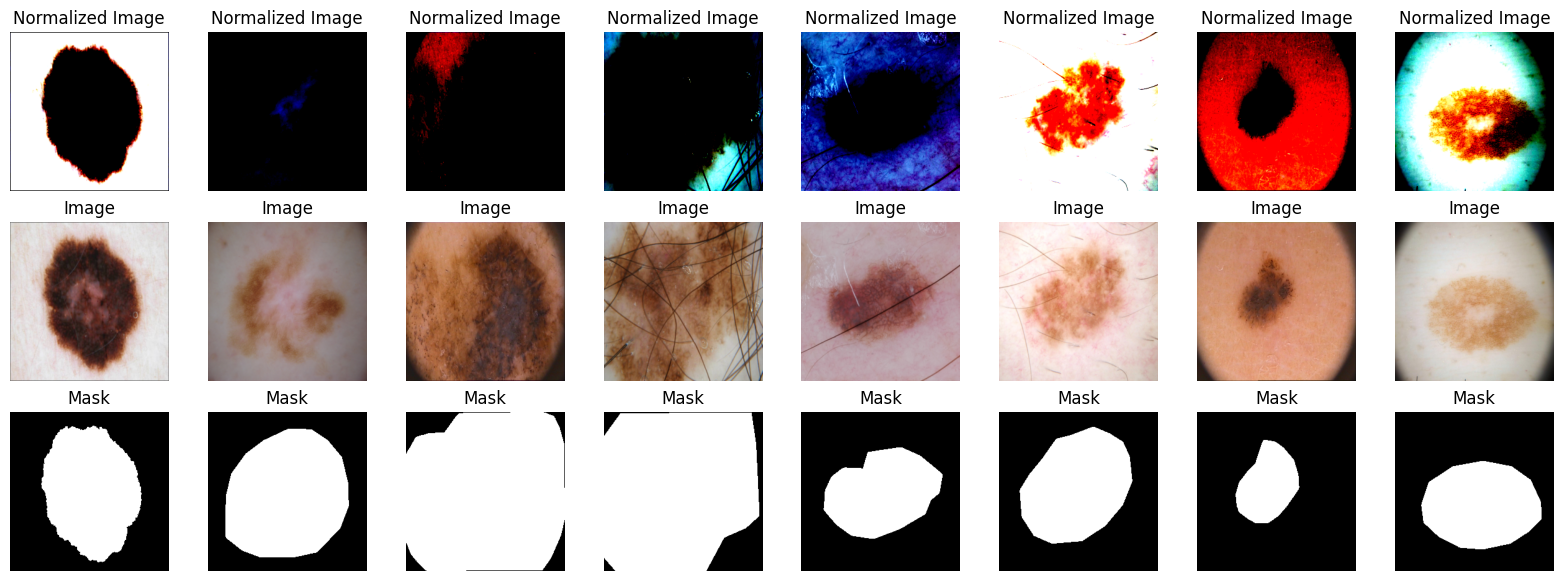

In [6]:
import matplotlib.pyplot as plt

# function that displays batch of images and masks
def show_batch(images, masks, raw):
    fig, ax = plt.subplots(3, 8, figsize=(20, 7))
    for i in range(8):
        ax[0][i].imshow(images[i].permute(1, 2, 0).clamp(0, 1))
        ax[0][i].set_title("Normalized Image")
        ax[0][i].axis("off")
        ax[1][i].imshow(raw[i].permute(1, 2, 0))
        ax[1][i].set_title("Image")
        ax[1][i].axis("off")
        ax[2][i].imshow(masks[i][0], cmap="gray")
        ax[2][i].set_title("Mask")
        ax[2][i].axis("off")
    plt.show()

show_batch(images, masks, raw)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder: Downsampling path
        self.encoder1 = DoubleConv(in_channels, 64)
        self.encoder2 = DoubleConv(64, 128)
        self.encoder3 = DoubleConv(128, 256)
        self.encoder4 = DoubleConv(256, 512)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder: Upsampling path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(128, 64)

        # Output layer
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        # Output layer
        output = self.output_conv(dec1)
        return output


In [9]:
# Initialize the model
model = UNet(in_channels=3, out_channels=1)

# Create a dummy input tensor and pass it through the model
input_tensor = torch.randn(8, 3, 256, 256)
output = model(input_tensor)

print(f"Output shape: {output.shape}")

Output shape: torch.Size([8, 1, 256, 256])


In [10]:
# Paths
train_images_dir = f"{data_dir}/training_images"
train_masks_dir = f"{data_dir}/training_masks"
test_images_dir = f"{data_dir}/test_images"
test_masks_dir = f"{data_dir}/test_masks"

# Datasets
train_dataset = ISICDataset(images_dir=train_images_dir, masks_dir=train_masks_dir,
                            image_transform=image_transform, mask_transform=mask_transform)
test_dataset = ISICDataset(images_dir=test_images_dir, masks_dir=test_masks_dir,
                           image_transform=image_transform, mask_transform=mask_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [11]:
import torch.optim as optim

# Model, loss function, and optimizer
model = UNet(in_channels=3, out_channels=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Device: {device}")

Device: mps


In [13]:
model.to(device)

num_epochs = 15
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for images, masks, _ in train_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Print training loss for each epoch
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Evaluate on the test set
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for images, masks, _ in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_test_loss:.4f}")

    training_losses.append(avg_train_loss)
    validation_losses.append(avg_test_loss)

Epoch [1/15], Training Loss: 0.3945
Epoch [1/15], Validation Loss: 0.3728
Epoch [2/15], Training Loss: 0.3272
Epoch [2/15], Validation Loss: 0.5035
Epoch [3/15], Training Loss: 0.2933
Epoch [3/15], Validation Loss: 0.3362
Epoch [4/15], Training Loss: 0.2630
Epoch [4/15], Validation Loss: 0.2313
Epoch [5/15], Training Loss: 0.2555
Epoch [5/15], Validation Loss: 0.3028
Epoch [6/15], Training Loss: 0.2535
Epoch [6/15], Validation Loss: 0.2211
Epoch [7/15], Training Loss: 0.2361
Epoch [7/15], Validation Loss: 0.2261
Epoch [8/15], Training Loss: 0.2129
Epoch [8/15], Validation Loss: 0.2331
Epoch [9/15], Training Loss: 0.2069
Epoch [9/15], Validation Loss: 0.1958
Epoch [10/15], Training Loss: 0.2030
Epoch [10/15], Validation Loss: 0.1784
Epoch [11/15], Training Loss: 0.1869
Epoch [11/15], Validation Loss: 0.2084
Epoch [12/15], Training Loss: 0.1917
Epoch [12/15], Validation Loss: 0.2417
Epoch [13/15], Training Loss: 0.1891
Epoch [13/15], Validation Loss: 0.1962
Epoch [14/15], Training Loss: 

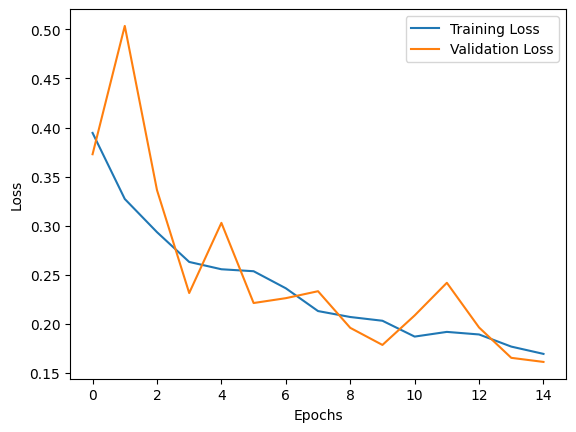

In [14]:
plt.figsize=(10, 5)
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

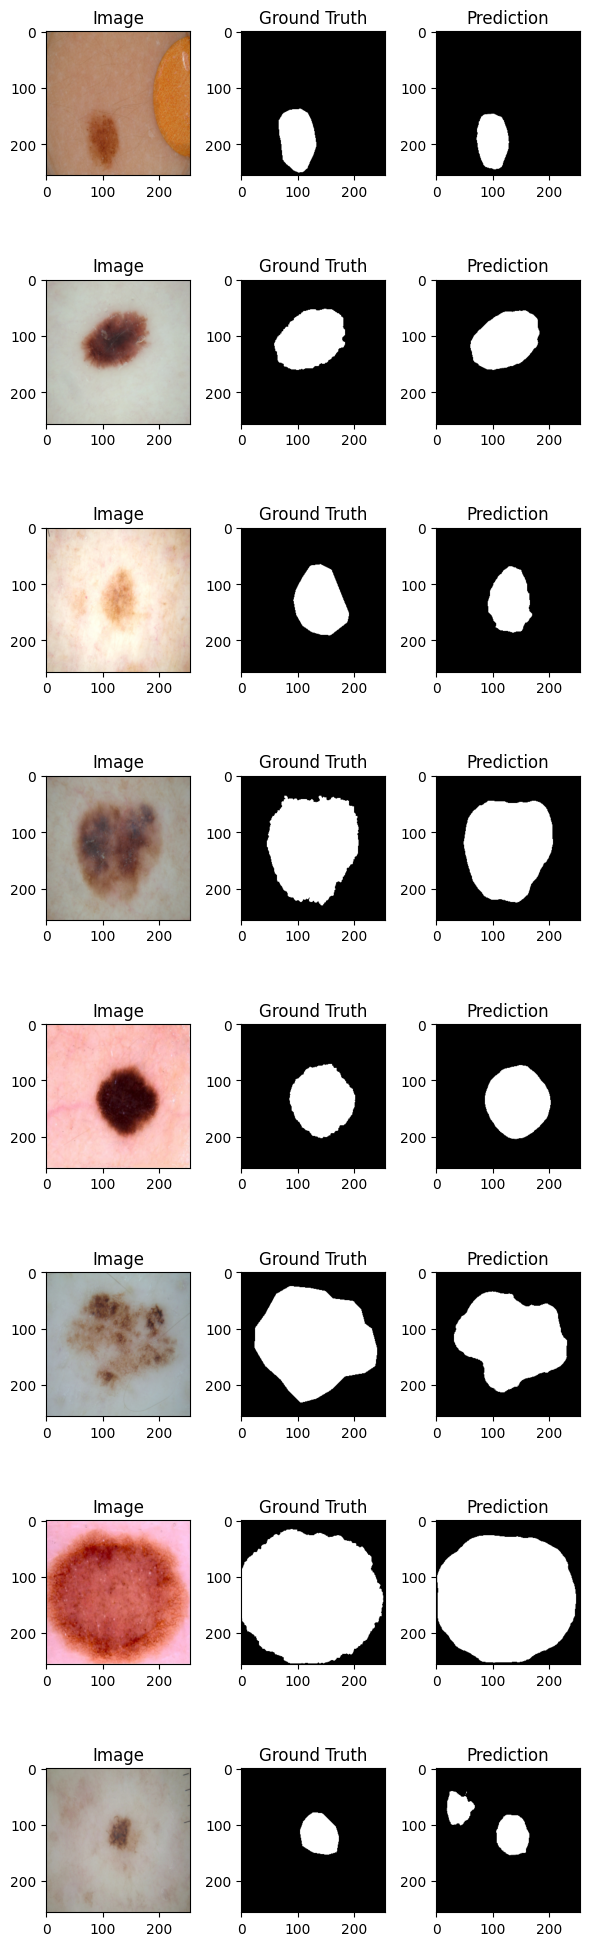

In [15]:
def visualize_predictions(images, masks, outputs):
    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    masks = masks.cpu().numpy()
    outputs = torch.sigmoid(outputs).detach().cpu().numpy()

    num_images = len(images)
    fig, ax = plt.subplots(num_images, 3, figsize=(6, 20))
    for i in range(num_images):
        ax[i][0].imshow(images[i])
        ax[i][0].set_title("Image")
        ax[i][1].imshow(masks[i][0], cmap="gray")
        ax[i][1].set_title("Ground Truth")
        ax[i][2].imshow(outputs[i][0] > 0.5, cmap="gray")
        ax[i][2].set_title("Prediction")

    plt.tight_layout()
    plt.show()

# Visualization of predictions
images, masks, raw = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)
outputs = model(images)
visualize_predictions(raw, masks, outputs)

In [16]:
# metrics Dice Coefficient and Intersection over Union
def dice_coefficient(outputs, masks):
    smooth = 1e-6
    outputs = outputs.view(-1)
    masks = masks.view(-1)
    intersection = (outputs * masks).sum()
    dice = (2. * intersection + smooth) / (outputs.sum() + masks.sum() + smooth)
    return dice

def intersection_over_union(outputs, masks):
    smooth = 1e-6
    outputs = outputs.view(-1)
    masks = masks.view(-1)
    intersection = (outputs * masks).sum()
    union = outputs.sum() + masks.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Evaluate the model on the test set
model.eval()
test_dice = 0
test_iou = 0

with torch.no_grad():
    for images, masks, _ in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        test_dice += dice_coefficient(torch.sigmoid(outputs), masks).item()
        test_iou += intersection_over_union(torch.sigmoid(outputs), masks).item()

# Dice Coefficient and Intersection over Union
avg_dice = test_dice / len(test_loader)
avg_iou = test_iou / len(test_loader)
print(f"Average Dice Coefficient: {avg_dice:.4f}")
print(f"Average Intersection over Union: {avg_iou:.4f}")

Average Dice Coefficient: 0.8218
Average Intersection over Union: 0.6997


In [17]:
# Save the model
torch.save(model.state_dict(), "unet_model.pth")